## importing dataset

In [ ]:
!pip install -q kaggle 
# from google.colab import files
# files.upload()

In [ ]:
!mkdir -p ~/ .kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c histopathologic-cancer-detection

100% 6.29G/6.31G [00:37<00:00, 172MB/s]
100% 6.31G/6.31G [00:37<00:00, 180MB/s]


In [ ]:
import zipfile
zip = zipfile.ZipFile('/content/histopathologic-cancer-detection.zip','r')
zip.extractall('/content')
zip.close()

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten

In [ ]:
from keras.utils import image_dataset_from_directory as idfd

In [ ]:
import pandas as pd

df = pd.read_csv('/content/train_labels.csv')

In [ ]:
df.isnull().sum()

id       0
label    0
dtype: int64

In [ ]:
len(df)

220025

In [ ]:
import os

dir_path = '/content/train'
image_exts = ['.tif']  # list of image extensions to count

num_images = sum([len(files) for r, d, files in os.walk(dir_path) if any(file.lower().endswith(tuple(image_exts)) for file in files)])

print(f'Total number of images in {dir_path}: {num_images}')


Total number of images in /content/train: 220025


In [ ]:
import cv2
import os

source_dir = '/content/train'
dest_dir = '/content/train1'

os.makedirs(dest_dir, exist_ok=True)


# create destination directory if it doesn't exist
if not os.path.exists(dest_dir):
    os.makedirs(dest_dir)

# loop over all .tif files in source directory
for filename in os.listdir(source_dir):
    if filename.endswith('.tif'):
        # read the image using OpenCV
        img = cv2.imread(os.path.join(source_dir, filename))

        # convert to RGB color space if necessary
        if img.shape[-1] == 1:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

        # save as .jpg in destination directory
        dest_path = os.path.join(dest_dir, filename.replace('.tif', '.jpg'))
        cv2.imwrite(dest_path, img)


In [ ]:
import os
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size=0.2)



# Define the source directories and destination directories
traindir = "/content/train_new"
valdir = "/content/val_new"
traincancer = "/content/train_new/cancer"
trainnoncancer = "/content/train_new/non_cancer"
valcancer = "/content/val_new/cancer"
valnoncancer = "/content/val_new/non_cancer"
# Create the destination directories if they don't exist
os.makedirs(traindir, exist_ok=True)
os.makedirs(valdir, exist_ok=True)
os.makedirs(trainnoncancer, exist_ok=True)
os.makedirs(traincancer, exist_ok=True)
os.makedirs(valnoncancer, exist_ok=True)
os.makedirs(valcancer, exist_ok=True)


# Copy the images to the destination directories based on their labels
for index, row in train_df.iterrows():
    filename = row["id"]+'.jpg'
    label = row["label"]
    if label == 0:
        src_path = os.path.join('/content/train1', filename)
        dest_path = os.path.join(trainnoncancer, filename)
    else:
        src_path = os.path.join('/content/train1', filename)
        dest_path = os.path.join(traincancer, filename)
    shutil.copyfile(src_path, dest_path)

  
for index, row in val_df.iterrows():
    filename = row["id"]+'.jpg'
    label = row["label"]
    if label == 0:
        src_path = os.path.join('/content/train1', filename)
        dest_path = os.path.join(valnoncancer, filename)
    else:
        src_path = os.path.join('/content/train1', filename)
        dest_path = os.path.join(valcancer, filename)
    shutil.copyfile(src_path, dest_path)


In [ ]:
from keras.utils import image_dataset_from_directory as idfd

In [ ]:
train_ds = idfd(
    directory = '/content/train_new',
    labels = 'inferred',
    label_mode = 'int',
    batch_size= 32,
    image_size = (256,256)
)

validation_ds = idfd(
    directory = '/content/val_new',
    labels = 'inferred',
    label_mode = 'int',
    batch_size= 32,
    image_size = (256,256)
)

Found 176020 files belonging to 2 classes.
Found 44005 files belonging to 2 classes.


In [ ]:
def normalise_process(image,label):
  image = tf.cast(image/255,tf.float32)
  return image,label

In [ ]:
train_ds = train_ds.map(normalise_process)
validation_ds = validation_ds.map(normalise_process)

In [ ]:
from keras.layers import BatchNormalization,Dropout

In [ ]:
model = Sequential()

model.add(Conv2D(32,kernel_size=(3,3),padding='valid',activation = 'relu',input_shape =(256,256,3) ))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides = 2,padding='valid'))

model.add(Conv2D(64,kernel_size=(3,3),padding='valid',activation = 'relu' ))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides = 2,padding='valid'))

model.add(Conv2D(128,kernel_size=(3,3),padding='valid',activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides = 2,padding='valid'))

model.add(Flatten())

model.add(Dense(128,activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(64,activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(1,activation = 'sigmoid'))

In [ ]:
model.compile(optimizer = 'adam',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
history = model.fit(train_ds,epochs=10,validation_data=validation_ds)

Epoch 1/10
3912/5501 [====================>.........] - ETA: 2:29 - loss: 0.1102 - accuracy: 0.9524

KeyboardInterrupt: ignored

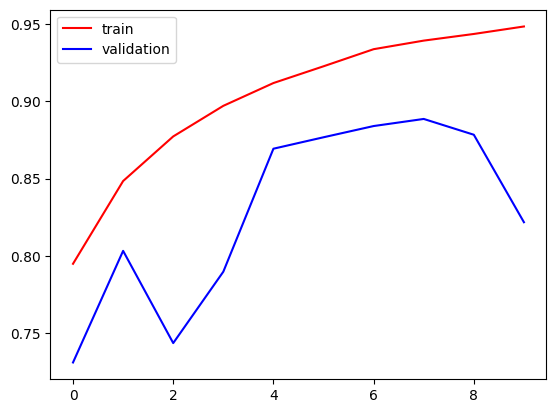

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()



In [ ]:
import os

directory = '/content/train'
invalid_files = []
valid_files= []

for filename in df['id']:
    filepath = os.path.join(directory, filename + '.tif')
    if not os.path.exists(filepath):
        invalid_files.append(filename)
    else:
      valid_files.append(filename)

print(len(valid_files))


220025


In [ ]:
model.save('model1.h5')

In [ ]:
from google.colab import files

files.download('/content/model1.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

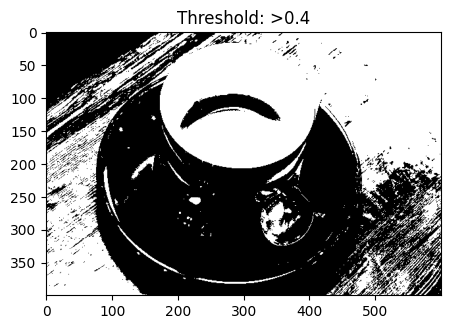

In [ ]:
# Importing Necessary Libraries
# Displaying the sample image - Monochrome Format
from skimage import data
from skimage import filters
from skimage.color import rgb2gray
import matplotlib.pyplot as plt

# Sample Image of scikit-image package
coffee = data.coffee()
gray_coffee = rgb2gray(coffee)

# Setting the plot size to 15,15
plt.figure(figsize=(15, 15))

i=4;

# Iterating different thresholds
binarized_gray = (gray_coffee > i*0.1)*1
plt.subplot(5,2,i+1)

# Rounding of the threshold
# value to 1 decimal point
plt.title("Threshold: >"+str(round(i*0.1,1)))

# Displaying the binarized image
# of various thresholds
plt.imshow(binarized_gray, cmap = 'gray')

plt.tight_layout()


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
import torch

def segment_image(model_path, img_path, img_shape=(256, 256), threshold=0.5):
    """
    Segment histopathologic cancer images using a U-Net model.

    Parameters:
    model_path (str): Path to the U-Net model (in h5 format).
    img_path (str): Path to the input image.
    img_shape (tuple): Desired shape of the input image.
    threshold (float): Threshold value for the binary mask.

    Returns:
    mask (ndarray): Binary mask of the segmented image.
    segmented_image (ndarray): Input image with segmentation overlay.
    """

    # Load the U-Net model
    model = load_model(model_path)

    # Read the input image and resize it to the desired shape
    img = cv2.imread(img_path)
    img = cv2.resize(img, img_shape)

    # Normalize the image to values between 0 and 1
    img = img / 255.0

    # Expand the image to a 4D tensor with an additional dimension for batch size
    img = np.expand_dims(img, axis=0)

    # Make a prediction using the U-Net model
    mask = model.predict(img)[0]

    # Threshold the predicted mask
    mask = (mask > threshold).astype(np.uint8)

    # Apply a binary closing operation to fill in small holes in the mask
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    # Convert the mask to a grayscale image
    mask = (mask * 255).astype(np.uint8)

    # Apply the mask to the original image
    segmented_image = cv2.bitwise_and(img[0], img[0], mask=mask)

    # Convert the segmented image to RGB and overlay it with the binary mask
    segmented_image = cv2.cvtColor(segmented_image, cv2.COLOR_GRAY2RGB)
    mask_overlay = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
    mask_overlay[:, :, 1:3] = 0.0
    segmented_image = cv2.addWeighted(segmented_image, 0.6, mask_overlay, 0.4, 0.0)

    return


In [ ]:
# Loop through each image in the directory and segment it
for file in os.listdir(directory):
    if file.endswith('.jpg') :
        with open('train_new', 'r') as f:
            lines = f.readlines()
            if not lines[2].strip():
    
                # Segment the image using the U-Net model and save it as a file
                img_path = os.path.join(directory, file)
                # img_path = './image.jpg'

                output_path = os.path.join('/content/train_new', file)
                segment_image('/content/model1.h5', img_path, (256,256), 0.5, output_path)


In [ ]:
segment_image('/content/model1.h5', '/content/train_new', img_shape=(256, 256), threshold=0.5)

error: ignored

In [ ]:
import tensorflow as tf

def apply_segmentation(dataset):
    # Define the segmentation model
    segmentation_model = tf.keras.applications.MobileNetV2(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet'
    )

    # Preprocess the images
    preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
    dataset = dataset.map(lambda x, y: (preprocess_input(x), y))

    # Apply the segmentation
    def segment_image(image, label):
        # Resize the image to match the input shape of the segmentation model
        image = tf.image.resize(image, (224, 224))

        # Apply the segmentation model to the image
        segmentation_result = segmentation_model(image)

        # Post-process the segmentation result
        segmentation_result = tf.keras.layers.GlobalAveragePooling2D()(segmentation_result)
        segmentation_result = tf.keras.layers.Dense(1, activation='sigmoid')(segmentation_result)

        # Combine the segmentation result with the input image
        image = tf.concat([image, segmentation_result], axis=-1)

        return image, label

    dataset = dataset.map(segment_image)

    return dataset

In [ ]:
train_ds_segmented = apply_segmentation(train_ds)
validation_ds_segmented = apply_segmentation(validation_ds)

ValueError: ignored

In [ ]:
!pip install git+https://github.com/tensorflow/models.git


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/models.git to /tmp/pip-req-build-s83hgy7e
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/models.git /tmp/pip-req-build-s83hgy7e
  Resolved https://github.com/tensorflow/models.git to commit e71d3a5e95a48c68b92ab928ebd5f63ba349266c
ERROR: git+https://github.com/tensorflow/models.git does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


In [ ]:
!pip install -U segmentation-models==0.2.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 5.9 MB/s eta 0:00:00


In [ ]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from keras.models import Model
from keras.applications.vgg16 import VGG16

In [ ]:
VGG_model = VGG16(weights = 'imagenet',include_top = False , input_shape = (256,256,3))
for layer in VGG_model.layers:
  layer.trainable = False

VGG_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [ ]:
new_model = Model(inputs=VGG_model.input, outputs=VGG_model.get_layer('block1_conv2').output)
new_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
Total params: 38,720
Trainable params: 0
Non-trainable params: 38,720
_________________________________________________________________


In [ ]:
import numpy as np

In [ ]:
train_ds

<_MapDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_ds[0][0])
plt.show()

TypeError: ignored

In [ ]:
train_ds_seg = train_ds.map(segment_image)

RuntimeError: ignored

In [ ]:
# Apply the segmentation function to the dataset
train_ds_seg = train_ds.map(segment_image)

# Visualize a sample from the dataset
image, mask = next(train_ds_seg)
plt.subplot(1, 2, 1)
plt.imshow(image[0])
plt.subplot(1, 2, 2)
plt.imshow(mask[0], cmap='gray')
plt.show()


In [ ]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

def preprocess_dataset(dataset, batch_size=16):
    images_lda = []
    labels = []
    pca = PCA(n_components=min(32, 16))
    lda = LinearDiscriminantAnalysis(n_components=25)
    images = np.empty((batch_size,) + dataset.element_spec[0].shape[1:] + (1,))  # add an additional dimension

    for image_batch, label_batch in dataset.batch(batch_size):
        images[:,:,:, 0] = image_batch.numpy()  # assign values to the first channel of the images array
        labels_batch = label_batch.numpy()

        # apply PCA
        images_pca = pca.fit_transform(images.reshape(-1, np.prod(images.shape[1:])))

        # apply LDA
        images_lda_batch = lda.fit_transform(images_pca, labels_batch)
        
        images_lda.append(images_lda_batch)
        labels.append(labels_batch)

    images_lda = np.concatenate(images_lda, axis=0)
    labels = np.concatenate(labels, axis=0)

    return images_lda, labels


train_ds_dr = preprocess_dataset(train_ds)
validation_ds_dr = preprocess_dataset(validation_ds)


ValueError: ignored